# Assignment 4: Sound Event Localization and Detection (SELD)


CS-GY 9223: Machine Listening

**Due:** Friday, April 23rd

**Read through the text, code, and comments carefully and fill-in the blanks accordingly. Written questions will be denoted with❓, and code questions will be explained in code comments, both with "TODO" markers.**

**For all plots, include axis labels with units of measurement when applicable. Lack of this will result in small points deductions.**

The assignment will be 10 points total, with 4 points of extra credit available.

⚠️ This assignment will be a bit more involved than previous assignments, with less template code and more freedom to structure your data pipeline and model training however you'd like.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
from glob import glob
import gc
import librosa
import soundfile as sf


# SELD Model Overview
For this assignment, you will implement, train, and evaluate a sound event localization and detection model, based on the framework discussed in class of [DCASE 2019 Task 3](https://dcase.community/challenge2019/task-sound-event-localization-and-detection).

Your SELD model will perform both **detection** (e.g. "is a sound event class present in a given frame?") and **localization** (e.g. "where is this sound event coming from?").

Model overview:
- **Model input**: magnitude and phase information from the STFT of 4-channel First Order Ambisonics (FOA) audio
- **Multi-task model output**: per 20ms frame (e.g. 50 fps x 60 sec = 3000 frames):
    - **SED output**: in the continuous range of [0,1] for each class. This will be thresholded (by some value, a good default is 0.5) for class activity detection in evaluation. Overall shape here will be `(batch, T, C)` where T is frame index and C is class index.
    - **DOA output**: in the continuous range of [-1,1] for each axes of the sound class location. Overall shape here will be `(batch, T, 3C)` where x, y, and z DOA coordinates are predicted for each class at each time frame.

The data processing, model architecture, and evaluation are detailed best in the paper released with this challenge [here](https://arxiv.org/pdf/1807.00129).

# SELD Task Figures
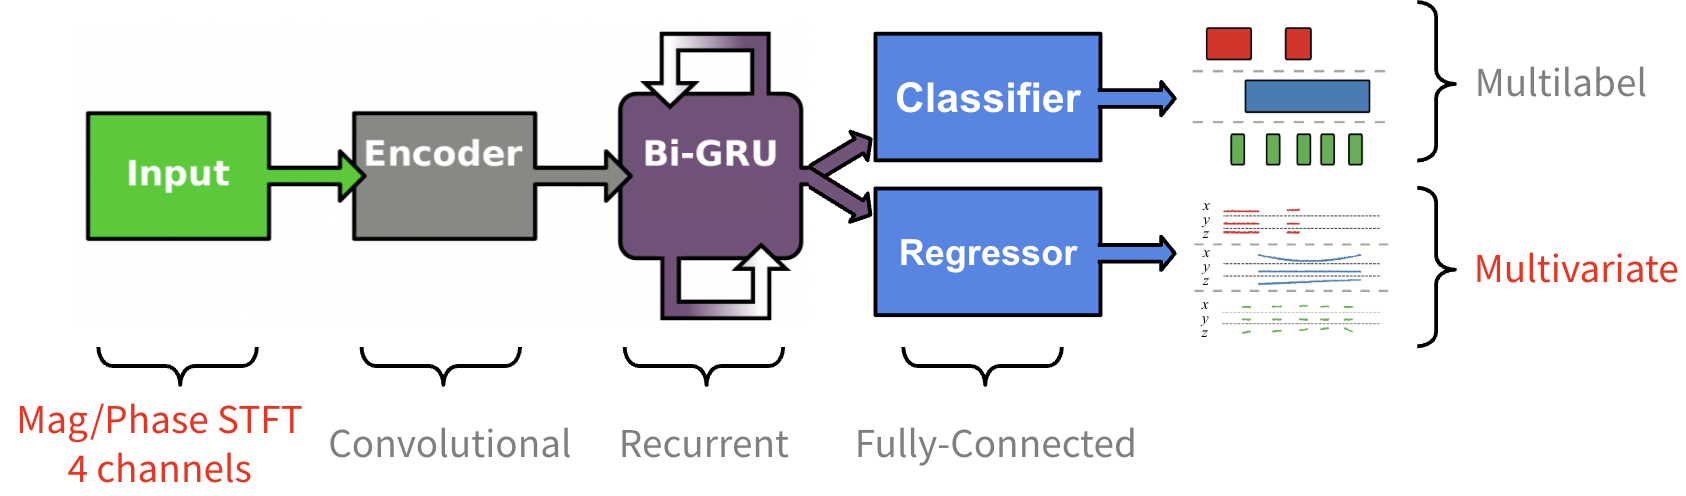



# Data
For this assignment, we will use the DCASE 2019 Task 3 dataset with a couple specifications:
- We will be using the 4-channel FOA (first-order Ambisonics) audio, not the "MIC" format.
- We will use the **development** dataset only, which has 400 1-minute recordings at 48kHz.
- There can be simultaneous sounds from different classes, but not from the same class.
- Use folds 3 and 4 for training, fold 2 for validation, and 1 for test.
- The recordings follow the following naming convention:
`split[number]_ir[location number]_ov[number of overlapping sound events]_[recording number per split].wav`.

## Getting the data
Download the DCASE FOA development dataset from Google Drive here: https://drive.google.com/drive/folders/1lTgUcnbHKO-BL2JSRXdtpI9SxaKfiOn_?usp=sharing. This contains the metadata and ambisonics audio.

Put these zip files in your Drive, then mount your drive and unzip the files running the code below.

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
!unzip "/content/drive/MyDrive/assignment4_files/metadata_dev.zip" -d "/content"

Archive:  /content/drive/MyDrive/assignment4_files/metadata_dev.zip
   creating: /content/metadata_dev/
  inflating: /content/metadata_dev/split1_ir0_ov1_1.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_10.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_2.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_3.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_4.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_5.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_6.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_7.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_8.csv  
  inflating: /content/metadata_dev/split1_ir0_ov1_9.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_11.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_12.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_13.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_14.csv  
  inflating: /content/metadata_dev/split1_ir0_ov2_15.csv  
  inflating: /conten

In [9]:

!unzip "/content/drive/MyDrive/assignment4_files/foa_dev_all_compressed.zip" -d "/content"

Archive:  /content/drive/MyDrive/assignment4_files/foa_dev_all_compressed.zip
  inflating: /content/__MACOSX/._foa_dev  
  inflating: /content/foa_dev/split3_ir2_ov1_42.wav  
  inflating: /content/foa_dev/split2_ir0_ov1_2.wav  
  inflating: /content/foa_dev/split3_ir1_ov2_35.wav  
  inflating: /content/__MACOSX/foa_dev/._split3_ir1_ov2_35.wav  
  inflating: /content/foa_dev/split1_ir4_ov2_95.wav  
  inflating: /content/foa_dev/split1_ir0_ov1_7.wav  
  inflating: /content/foa_dev/split4_ir1_ov2_36.wav  
  inflating: /content/foa_dev/split1_ir0_ov2_17.wav  
  inflating: /content/foa_dev/split4_ir2_ov1_41.wav  
  inflating: /content/foa_dev/split4_ir4_ov1_89.wav  
  inflating: /content/foa_dev/split2_ir2_ov1_46.wav  
  inflating: /content/foa_dev/split2_ir1_ov2_31.wav  
  inflating: /content/foa_dev/split4_ir0_ov1_8.wav  
  inflating: /content/__MACOSX/foa_dev/._split4_ir0_ov1_8.wav  
  inflating: /content/foa_dev/split3_ir3_ov2_80.wav  
  inflating: /content/foa_dev/split4_ir0_ov1_9.wav 

## Writing your dataloader
Design a PyTorch dataset class that extracts features from the 4-channel audio as described in class:

**Audio Features**
- Loads the 4-channel FOA waveform
- For each channel, get the magnitude and phase from the STFT if the audio. Use the parameters in the template dataloader below - I've figured this out for you so that the time bins align to 3000 to match the output desired T.
- Final feature dimension should be shape `(T x N/2 x 2K)`, where `N` is the length of your STFT window (N/2 because of positive frequencies only being used, discard 0th bin), T is the number of time frames (50 frames per second for 60 sec clip = 3000 frames per clip), and K is the number of channels (2K due to stacking K magnitude components and K phase components -> 2K = 8). TLDR: this should be of shape `(batch, 3000, 1024, 8)`.

**Labels**

Each input feature matrix should have two corresponding ground truth features:
- DOA ground truth: Overall shape here will be `(batch, T, 3C)` where x, y, and z are DOA coordinates are for each class at each time frame. Note that the metadata contains this position in elevation and azimuth instead of cartesian coordinates. We will evaluate in elevation and azimuth, but for training, use cartesian. You can convert between the two with the helper functions I've provided below.
- SED ground truth: Overall shape here will be `(batch, T, C)` where T is frame index and C is class index. This is 1 if a sound class is present in a given frame and 0 otherwise.


Other important dataloader notes:
- Your dataloader should take a data split argument, and filter the audio and metadata files to only load the corresponding splits based on the fold information above. See the example in the last assignment for help on this.
- There are 11 sound event classes. You will need to map the string from `sound_event_recording` to a class index, building off of something like this: `class_list = ['clearthroat','cough','doorslam','drawer', 'keyboard',
 'keysDrop',
 'knock',
 'laughter',
 'pageturn',
 'phone',
 'speech']`

### ❗Deliverables❗
- Data loader class
- Print the shapes of your input features and 2 sets of ground truth labels while running a sample batch iteration through your dataloader
- Plot the spectrogram of one channel of one of the audio files and also plot the corresponding SED labels. Check that these align and everything is making sense.

In [40]:
# TODO : Build your dataloader!

def next_greater_power_of_2(x): # just a helper
    return 2 ** (x - 1).bit_length()

class SELDDataset(Dataset):
    def __init__(self, csv_dir, audio_dir, data_split, cache_dir=None):
        """
        Args:
            csv_dir (str): Directory containing CSV files, one per audio clip.
            audio_dir (str): Directory containing audio files, one per audio clip.
            data_split (str): train, val, test split specification.
        """
        self.class_list = ['clearthroat','cough','doorslam','drawer', 'keyboard', 'keysDrop', 'knock', 'laughter', 'pageturn', 'phone', 'speech']
        self.num_classes = len(self.class_list)

        # STFT params, keep these for ease of dimensionality and time alignment
        self.sample_rate = 48000
        self.frame_hop = 0.2 # for meta
        self.hop_len = int(self.sample_rate * 0.02) # for spec
        self.win_len = 2 * self.hop_len
        self.nfft = next_greater_power_of_2(self.win_len)
        self.duration = 60
        self.T = int(self.duration / 0.02) # total number of frames

        self.data_split = data_split

        self.cache_dir = cache_dir or os.path.join(audio_dir, 'cache')
        os.makedirs(self.cache_dir, exist_ok=True)



        # ! TODO : everything else in your dataloader init
        if self.data_split == 'train':
            self.fold = [3,4]
        elif self.data_split == 'val':
            self.fold = [2]
        elif self.data_split == 'test':
            self.fold = [1]
        else:
          raise ValueError("Split should be train, val or test")


        self.meta_paths = []
        self.audio_paths = []

        for fold in self.fold:
          # Get all .wav files for specific fold #
          nfold_audio_files = glob(os.path.join(audio_dir, f'split{fold}_*.wav'))
          print(f"Found {len(nfold_audio_files)} audio files in fold {fold}")
          for audio_file in nfold_audio_files:
            file_name = os.path.splitext (os.path.basename (audio_file)) [0]
            metadata_file = os.path.join(csv_dir, file_name + '.csv')
            if os.path.exists(metadata_file):
              self.audio_paths.append(audio_file)
              self.meta_paths.append(metadata_file)
            else:
              print ("Metadata file not found for (audio file}")

       # assert len(self.meta_paths) == len(self.audio_paths),\
        #  f"Number of metadata files ({len(self.meta_paths)}) does not match number of audio files ({len(self.audio_paths)})"


        self.class_to_index = {c: i for i, c in enumerate(self.class_list)}
        self._build_cache()

    def _build_cache(self):

      for wav_path, meta_path in zip(self.audio_paths, self.meta_paths):

        stem = os.path.splitext(os.path.basename(wav_path))[0]
        cache_path = os.path.join(self.cache_dir, stem + ".pt")
        if not os.path.exists(cache_path):
          audio, sr = sf.read(wav_path)
          spec_feats = self.get_phase_mag(audio)
          doa_mat, sed_mat = self.get_doa_sed_from_meta(meta_path)

          torch.save({
              'spec_feats': torch.from_numpy(spec_feats),
              'doa_mat': torch.from_numpy(doa_mat),
              'sed_mat': torch.from_numpy(sed_mat)
          }, cache_path)


    def __len__(self):
        # TODO
        return len(self.audio_paths)

    def get_phase_mag(self, audio):
      n_bins = (self.nfft) // 2
      features = np.zeros((self.T,n_bins,8),dtype=np.float32)

      for ch in range(4):
        stft = librosa.stft(audio[:,ch],n_fft=self.nfft,hop_length=self.hop_len,win_length=self.win_len)

        mag, phase = librosa.magphase(stft)

        mag = mag[1:,:self.T]
        phase_angles = np.angle(phase[1:,:self.T])


        if mag.shape[1] < self.T:
          pad_width = ((0, 0), (0, self.T - mag. shape [1]))
          mag = np.pad (mag, pad_width, mode='constant')
          phase_angles = np.pad (phase_angles, pad_width, mode='constant')
        elif mag.shape[1] > self.T:
          mag = mag[:,:self.T]
          phase_angles = phase_angles[:,:self.T]


        features[:,:,ch] = mag.T
        features[:,:,4+ch] = phase_angles.T

      return features

    def get_doa_sed_from_meta(self, meta_path):
      doa_matrix = np.zeros ((self.T, 3 * self.num_classes), dtype=np.float32)
      sed_matrix = np.zeros((self.T, self.num_classes), dtype=np.float32)

      metadata_df = pd.read_csv(meta_path)

      for index,row in metadata_df.iterrows():
        class_name = row['sound_event_recording']
        class_index = self.class_list.index(class_name)

        start_frame = int(row['start_time'] / 0.02)
        end_frame = int(row['end_time'] / 0.02)

        start_frame = max(0, start_frame)
        end_frame = min(self.T, end_frame)

        sed_matrix[start_frame:end_frame, class_index] = 1

        azimuth = np.deg2rad(row['azi'])
        elevation = np.deg2rad(row['ele'])

        x, y, z = sph2cart(azimuth, elevation, 1)


        for frame in range(start_frame, end_frame):
          doa_matrix[frame, 3 * class_index] = x
          doa_matrix[frame, 3 * class_index + 1] = y
          doa_matrix[frame, 3 * class_index + 2] = z

      return doa_matrix, sed_matrix

    def __getitem__(self, idx):
        #spec_feats, doa_matrix, sed_matrix = None
        # TODO
        # A lot of code here for compute audio features and metadata processing
        # Recommend separating this into two helper functions
        # Remember to use the sph2cart helper functions such that you are working in Cartesian

        # audio, sr = sf.read(self.audio_paths[idx])

        # spec_feats = self.get_phase_mag(audio)

        # doa_mat, sed_mat = self.get_doa_sed_from_meta(self.meta_paths[idx])

        # spec_feats = torch.FloatTensor(spec_feats)
        # doa_matrix = torch.FloatTensor(doa_mat)
        # sed_matrix = torch.FloatTensor(sed_mat)

        # return spec_feats, doa_matrix, sed_matrix

        wav_path = self.audio_paths[idx]
        stem = os.path.splitext(os.path.basename(wav_path))[0]
        cache_path = os.path.join(self.cache_dir, stem + ".pt")

        data = torch.load(cache_path)
        return data["spec_feats"], data["doa_mat"], data["sed_mat"]


In [41]:
# Helper functions for spherical (azimuth and elevation) to cartesian (x,y,z)
def sph2cart(azimuth, elevation, r):
    '''
    Convert spherical to cartesian coordinates

    :param azimuth: in radians
    :param elevation: in radians
    :param r: in meters
    :return: cartesian coordinates
    '''

    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def cart2sph(x, y, z):
    '''
    Convert cartesian to spherical coordinates

    :param x:
    :param y:
    :param z:
    :return: azi, ele in radians and r in meters
    '''

    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r


In [42]:
# TODO
# Testing your dataloader and printing shapes of each component returned by get_item()
csv_dir = '/content/metadata_dev'
audio_dir = '/content/foa_dev'
data_split = 'train'
cache_dir = '/content/foa_dev/cache'

dataset = SELDDataset(csv_dir, audio_dir, data_split='train', cache_dir = cache_dir)

for spec_feats, doa_matrix, sed_matrix in dataset:
  print("Feature shape:", spec_feats.shape)
  print("DOA_shape:", doa_matrix.shape)
  print("SED_shape:", sed_matrix.shape)
  break



Found 100 audio files in fold 3
Found 100 audio files in fold 4
Feature shape: torch.Size([3000, 1024, 8])
DOA_shape: torch.Size([3000, 33])
SED_shape: torch.Size([3000, 11])


<ipython-input-43-d90a7710e1b5>:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  spec_db = librosa.amplitude_to_db(np.abs(spec_mag))


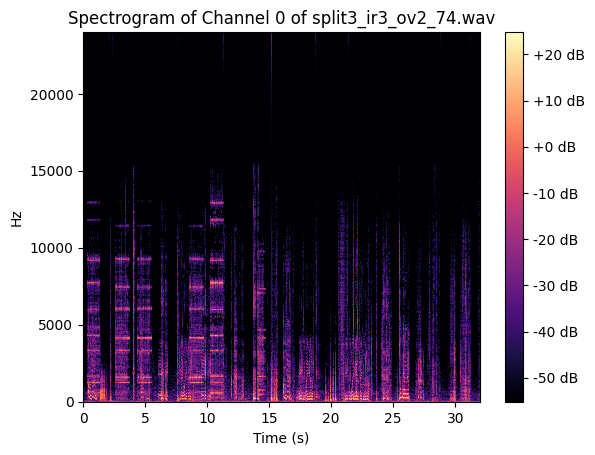

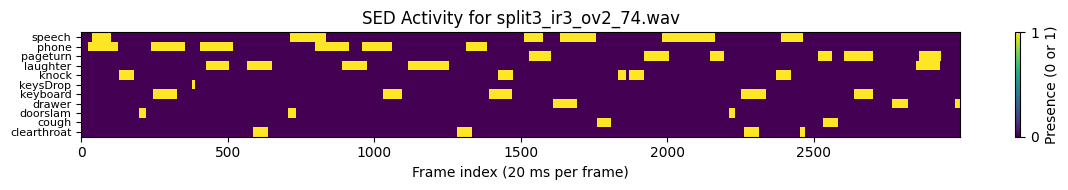

In [43]:
import matplotlib.pyplot as plt

sample_index = 4

spec_feats, doa_matrix, sed_matrix = dataset[sample_index]
file_name = os.path.basename(dataset.audio_paths[sample_index])

channel_index = 0

spec_mag = spec_feats[:,:,channel_index].T
spec_db = librosa.amplitude_to_db(np.abs(spec_mag))
librosa.display.specshow(spec_db, sr=dataset.sample_rate, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.title(f'Spectrogram of Channel {channel_index} of {file_name}')
plt.show()

plt.figure(figsize=(12, 2))
plt.imshow(
    sed_matrix.T,
    origin='lower',
    aspect='auto',
    interpolation='nearest'
)
plt.yticks(
    np.arange(len(dataset.class_list)),
    dataset.class_list,
    fontsize=8
)
plt.xlabel('Frame index (20 ms per frame)')
plt.title(f'SED Activity for {file_name}')
plt.colorbar(label='Presence (0 or 1)', ticks=[0,1])
plt.tight_layout()
plt.show()







# Building your SELD model
Using the architecture explained in class and pictured, design a SELD PyTorch model. Recall the model input and output:

- **Model input**: magnitude and phase information from the STFT of 4-channel First Order Ambisonics (FOA) audio
- **Multi-task model output**: per 20ms frame (e.g. 3000 frames per 1 min clip):
    - **SED output**: in the continuous range of [0,1] for each class. This will be thresholded >0.5 for class activity detection in evaluation. Overall shape here will be `(batch, T, C)` where T is frame index and C is class index.
    - **DOA output**: in the continuous range of [-1,1] for each axes of the sound class location. Overall shape here will be `(batch, T, 3C)` where x, y, and z DOA coordinates are predicted for each class at each time frame.

Other notes on model architecture:
- Follow the parameters shown in slide 55 (lecture 7) from class for the architecture parameters as closely as possible (e.g. P, MP, Q, R, C). Note that the STFT parameters used above (N,T) are different than what was shown in class.

### ❗Deliverables❗
- Model architecture class
- Print the architecture and number of parameters of your model


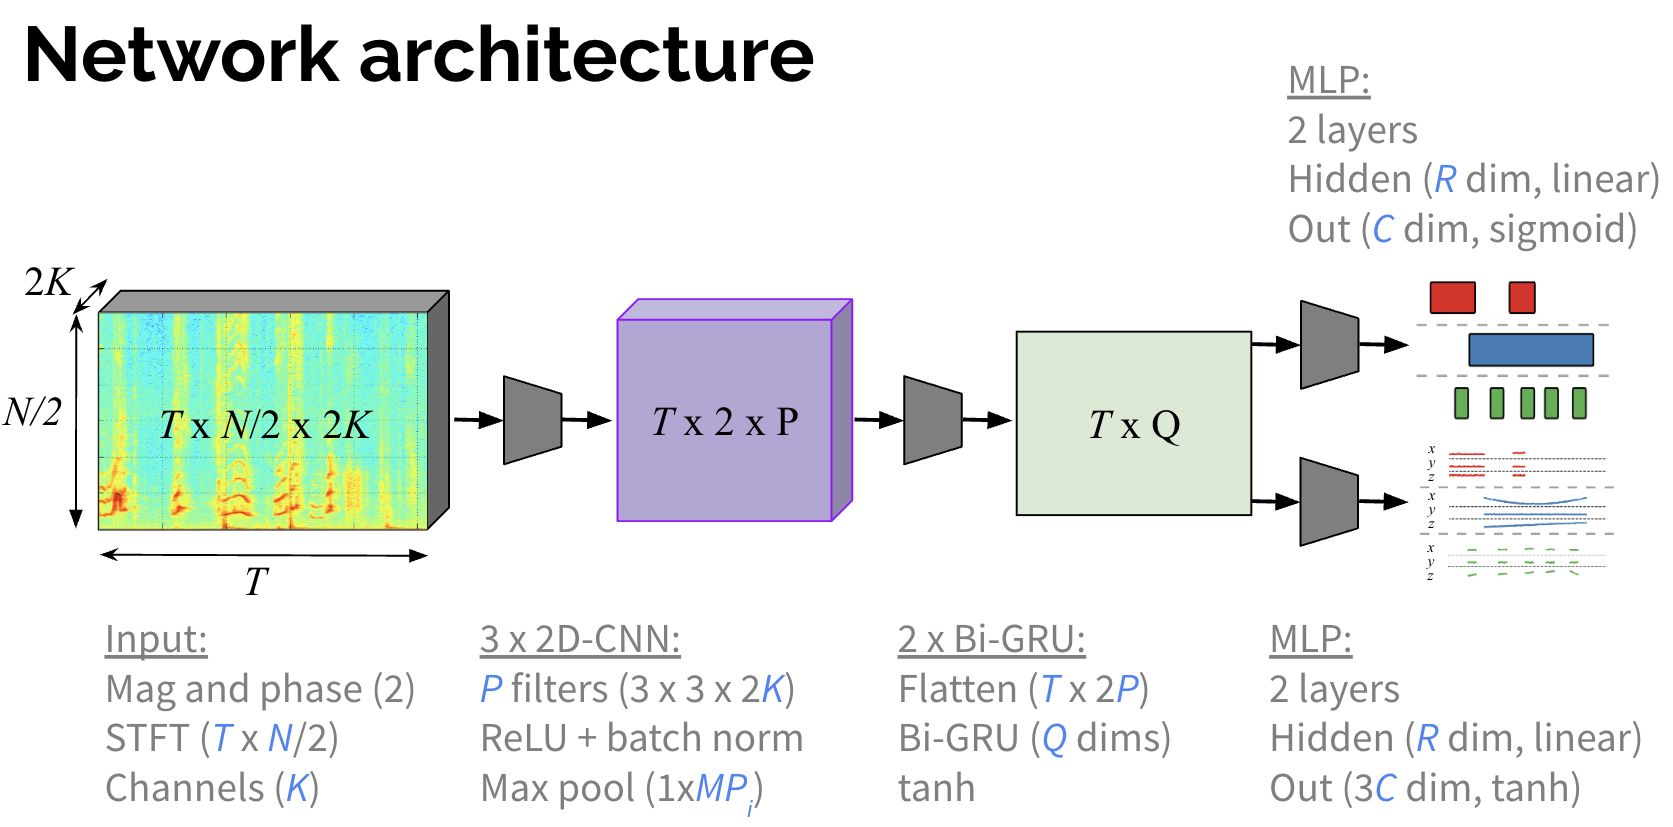

In [49]:
# TODO : Build your model!

class SELDModel(nn.Module):
    def __init__(self, input_channels = 8, hidden_size = 128, num_classes=11):
        super(SELDModel, self).__init__()


        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size= 3 , padding=1 ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,32))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size= 3, padding=1 ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,8))
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64,64, kernel_size= 3, padding=1 ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,2))
        )

        self.bi_gru = nn.GRU(
            128,
            hidden_size = hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True
            )

        self.sed_mlp = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, num_classes),
            nn.Sigmoid()
        )

        self.doa_mlp = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 3*num_classes),
            nn.Tanh()
        )





    def forward(self, x):

        """
        Args:
            x (Tensor): input tensor of shape (batch_size, time, freq, channels)
                        where channels = 2 × number of FOA channels (mag + phase)
        Returns:
            sed_output: Tensor of shape (batch_size, time, num_classes)
            doa_output: Tensor of shape (batch_size, time, 3 × num_classes)
        """
            # bring channels up front for Conv2d
        # → (B, C_in=8, F=512, T)
        x = x.permute(0, 3, 1, 2)


        # three conv blocks (pool only freq → F→2)
        x = self.conv1(x)   # → (B, P, F/8, T)
        x = self.conv2(x)   # → (B, P, F/8/8, T)
        x = self.conv3(x)   # → (B, P, 2,      T)

        x = x.permute(0, 2, 1, 3)
        x = x.reshape(x.size(0), x.size(1), -1)

        # Bi-GRU sequence modeling

        rnn_out, _ = self.bi_gru(x)

        # two heads
        sed = self.sed_mlp(rnn_out)   # → (B, T, C)
        doa = self.doa_mlp(rnn_out)   # → (B, T, 3C)

        return sed, doa


In [50]:
# TODO
# Print the model architecture and number of parameters
# 1) Instantiate with example hyper-params
model = SELDModel(
    input_channels=8,   # 2K = mag+phase of 4 channels
    hidden_size=128,     # GRU hidden size per direction
    num_classes=11       # number of classes
)

# 2) Print architecture
print(model)

# 3) Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

SELDModel(
  (conv1): Sequential(
    (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(1, 32), stride=(1, 32), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (bi_gru): GRU(128, 128, num_layers=2, batch_fir

# Training your model
Train and validate your model. Use sample code from the previous assignment for a template on training and validation scripts.

For the **loss** function, follow the loss explained in class (pictured). Note the proposed optimal weighting params were $ Β = 50*\alpha$.

Train for 100 epochs. Note that on the collab A100, with batch size 2 (for out of memory issues), one training+validation loop was taking 2 minutes for me.

### ❗Deliverables❗
- Training and validation code
- Plot the training and validation total loss curves (monitor this during training!)
- Plot the training and validation loss curves broken down by the weighted SED and SEL components.
- Save the best model based on validation loss (locally), you will need it for evaluation below.


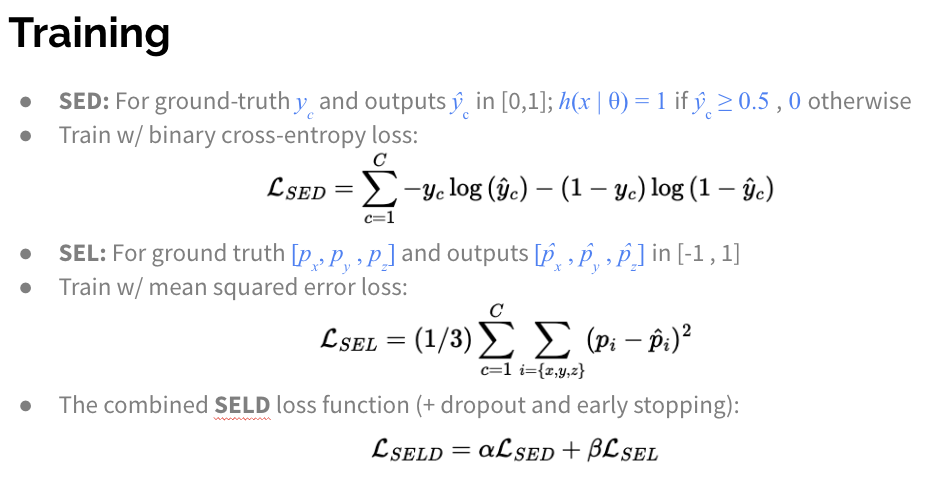

In [55]:
# TODO : All training and valid code

from torch.utils.data import DataLoader
import torch.optim as optim
from torch.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import f1_score


def train_and_validate(device, lr, train_dataloader, val_dataloader, num_epochs=100, alpha=1.0, beta=50.0, weight_decay=1e-5, sed_loss_fn = None):
    # Instantiate model
    model = SELDModel().to(device)

    model = torch.compile(model, mode='reduce-overhead')

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    # Loss functions
    #sed_loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    sed_loss_fn = sed_loss_fn
    doa_loss_fn = nn.MSELoss(reduction='mean')

    train_losses, val_losses = [], []
    train_sed_losses, val_sed_losses = [], []
    train_doa_losses, val_doa_losses = [], []

    best_val_loss = np.inf

    scaler = GradScaler()

    epochs_not_improved = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()

        train_sed_preds, train_sed_targs = [], []
        epoch_train_loss = 0.0
        epoch_train_sed_loss = 0.0
        epoch_train_doa_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, doa_targets, sed_targets in tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}"):
            inputs = inputs.to(device, non_blocking=True)
            sed_targets = sed_targets.to(device, non_blocking=True)
            doa_targets = doa_targets.to(device, non_blocking=True)

            # Zero gradients
            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type='cuda'):
                sed_outputs, doa_outputs = model(inputs)
                sed_loss = sed_loss_fn(sed_outputs, sed_targets)
                doa_loss = doa_loss_fn(doa_outputs, doa_targets)/3
                total_loss = alpha * sed_loss + beta * doa_loss

            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_size = inputs.size(0)
            epoch_train_loss += total_loss.item() * batch_size
            epoch_train_sed_loss += sed_loss.item() * batch_size
            epoch_train_doa_loss += doa_loss.item() * batch_size

            # Accumulate predictions for accuracy calculation
            sed_prob  = torch.sigmoid(sed_outputs)
            avg_p = sed_prob.mean().item()
            print(f"  [DEBUG] avg SED prob = {avg_p:.3f}")
            sed_preds = (sed_prob >= 0.5).float()

            B, T, C = sed_preds.shape

            train_sed_preds.append( sed_preds.detach().cpu().reshape(-1, C) )
            train_sed_targs.append( sed_targets.detach().cpu().reshape(-1, C) )

            correct_preds += (sed_preds == sed_targets).sum().item()
            total_preds += sed_targets.numel()


        all_train_preds = torch.cat(train_sed_preds, dim=0).numpy()
        all_train_targs = torch.cat(train_sed_targs, dim=0).numpy()
        train_f1 = f1_score(all_train_targs, all_train_preds, average='macro')

        # Validation loop
        model.eval()

        val_sed_preds, val_sed_targs = [], []
        epoch_val_loss = 0.0
        epoch_val_sed_loss = 0.0
        epoch_val_doa_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0



        with torch.no_grad():
            for inputs, doa_targets, sed_targets in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}"):
                inputs = inputs.to(device)
                sed_targets = sed_targets.to(device)
                doa_targets = doa_targets.to(device)

                sed_outputs, doa_outputs = model(inputs)
                sed_loss = sed_loss_fn(sed_outputs, sed_targets)
                doa_loss = doa_loss_fn(doa_outputs, doa_targets) / 3
                total_loss = alpha * sed_loss + beta * doa_loss

                batch_size = inputs.size(0)
                epoch_val_loss += total_loss.item() * batch_size
                epoch_val_sed_loss += sed_loss.item() * batch_size
                epoch_val_doa_loss += doa_loss.item() * batch_size



                # Accumulate predictions for accuracy calculation
                sed_prob  = torch.sigmoid(sed_outputs)
                avg_p = sed_prob.mean().item()
                print(f"  [DEBUG] avg SED prob = {avg_p:.3f}")
                sed_preds = (sed_prob >= 0.2).float()


                B, T, C = sed_preds.shape
                val_sed_preds.append( sed_preds.cpu().reshape(-1, C) )
                val_sed_targs.append( sed_targets.cpu().reshape(-1, C) )

                correct_val_preds += (sed_preds == sed_targets).sum().item()
                total_val_preds += sed_targets.numel()

        # Compute averages
        train_loss = epoch_train_loss / len(train_dataloader.dataset)
        val_loss = epoch_val_loss / len(val_dataloader.dataset)
        weighted_train_sed = alpha * epoch_train_sed_loss / len(train_dataloader.dataset)
        weighted_train_doa = beta * epoch_train_doa_loss / len(train_dataloader.dataset)
        weighted_val_sed = alpha * epoch_val_sed_loss / len(val_dataloader.dataset)
        weighted_val_doa = beta * epoch_val_doa_loss / len(val_dataloader.dataset)
        train_acc = correct_preds / total_preds
        val_acc = correct_val_preds / total_val_preds

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_sed_losses.append(weighted_train_sed)
        train_doa_losses.append(weighted_train_doa)
        val_sed_losses.append(weighted_val_sed)
        val_doa_losses.append(weighted_val_doa)


        all_val_preds = torch.cat(val_sed_preds, dim=0).numpy()
        all_val_targs = torch.cat(val_sed_targs, dim=0).numpy()
        val_f1 = f1_score(all_val_targs, all_val_preds, average='macro')

        # Step the scheduler
        scheduler.step(val_losses[-1])

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_not_improved = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': best_val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_sed_losses': train_sed_losses,
                'val_sed_losses': val_sed_losses,
                'train_doa_losses': train_doa_losses,
                'val_doa_losses': val_doa_losses,
            }, 'best_seld_model.pth')
            print(f"Saved new best model at epoch {epoch+1} with val loss: {best_val_loss:.4f}")
        else:
          epochs_not_improved += 1
          if epochs_not_improved >= 10:
              print(f"No improvement in validation loss for {epochs_not_improved} epochs. Early stopping.")
              break



        # Logging
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f" Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
        print(f"   Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}\n")



    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_sed_loss': train_sed_losses,
        'train_doa_loss': train_doa_losses,
        'val_sed_loss': val_sed_losses,
        'val_doa_loss': val_doa_losses,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_f1': train_f1,
        'val_f1': val_f1,
        'model': model
    }



In [57]:
csv_dir = '/content/metadata_dev'
audio_dir = '/content/foa_dev'
cache_dir = '/content/foa_dev/cache/'

train_dataset = SELDDataset(csv_dir, audio_dir, data_split='train', cache_dir=cache_dir)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ', device)

all_sed = []
for _, _, sed in train_dataset:              # sed is shape (T, C)
    all_sed.append(sed.numpy())

all_sed = np.concatenate(all_sed, axis=0)    # shape (N_frames_total, C)
pos_counts = all_sed.sum(axis=0)             # how many 1’s per class
neg_counts = all_sed.shape[0] - pos_counts   # total frames minus positives

# avoid divide‐by‐zero for any empty class
pos_counts = np.maximum(pos_counts, 1)

raw_pw = neg_counts / pos_counts


damped_pw = torch.from_numpy(np.sqrt(raw_pw).astype(np.float32)).to(device)

sed_loss_fn = nn.BCEWithLogitsLoss(
    reduction='mean',
    pos_weight=damped_pw
)

val_dataset = SELDDataset(csv_dir, audio_dir, data_split='val', cache_dir=cache_dir)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)

test_dataset = SELDDataset(csv_dir, audio_dir, data_split='test', cache_dir=cache_dir)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=True)

# Check one batch
sample_batch = next(iter(train_dataloader))
spec_feats, doa_matrix, sed_matrix = sample_batch
print(f"Feature shape: {spec_feats.shape}")  # Should be [2, 3000, 1024, 8]
print(f"DOA matrix shape: {doa_matrix.shape}")  # Should be [2, 3000, 33]
print(f"SED matrix shape: {sed_matrix.shape}")  # Should be [2, 3000, 11]


Found 100 audio files in fold 3
Found 100 audio files in fold 4
Device:  cuda
Found 100 audio files in fold 2
Found 100 audio files in fold 1
Feature shape: torch.Size([8, 3000, 1024, 8])
DOA matrix shape: torch.Size([8, 3000, 33])
SED matrix shape: torch.Size([8, 3000, 11])


In [53]:
# If you are getting OOM run these lines
import gc
gc.collect()
torch.cuda.empty_cache()

In [58]:
metrics = train_and_validate(
    device=device,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=100,
    lr=1e-4,
    alpha=1.0,
    beta=0.1,
    sed_loss_fn=sed_loss_fn
)

best_model = metrics['model']

Train Epoch 1:   4%|▍         | 1/25 [00:09<03:40,  9.17s/it]

  [DEBUG] avg SED prob = 0.622


Train Epoch 1:   8%|▊         | 2/25 [00:09<01:29,  3.90s/it]

  [DEBUG] avg SED prob = 0.620


Train Epoch 1:  12%|█▏        | 3/25 [00:09<00:48,  2.21s/it]

  [DEBUG] avg SED prob = 0.619


Train Epoch 1:  16%|█▌        | 4/25 [00:09<00:29,  1.42s/it]

  [DEBUG] avg SED prob = 0.617


Train Epoch 1:  20%|██        | 5/25 [00:09<00:19,  1.02it/s]

  [DEBUG] avg SED prob = 0.616


Train Epoch 1:  24%|██▍       | 6/25 [00:10<00:13,  1.39it/s]

  [DEBUG] avg SED prob = 0.614


Train Epoch 1:  28%|██▊       | 7/25 [00:10<00:09,  1.81it/s]

  [DEBUG] avg SED prob = 0.613


Train Epoch 1:  32%|███▏      | 8/25 [00:10<00:07,  2.26it/s]

  [DEBUG] avg SED prob = 0.611


Train Epoch 1:  36%|███▌      | 9/25 [00:11<00:08,  1.86it/s]

  [DEBUG] avg SED prob = 0.610


Train Epoch 1:  40%|████      | 10/25 [00:11<00:06,  2.29it/s]

  [DEBUG] avg SED prob = 0.608


Train Epoch 1:  44%|████▍     | 11/25 [00:11<00:05,  2.73it/s]

  [DEBUG] avg SED prob = 0.606


Train Epoch 1:  48%|████▊     | 12/25 [00:11<00:04,  3.15it/s]

  [DEBUG] avg SED prob = 0.605


Train Epoch 1:  52%|█████▏    | 13/25 [00:12<00:03,  3.52it/s]

  [DEBUG] avg SED prob = 0.604


Train Epoch 1:  56%|█████▌    | 14/25 [00:12<00:02,  3.84it/s]

  [DEBUG] avg SED prob = 0.602


Train Epoch 1:  60%|██████    | 15/25 [00:12<00:02,  4.08it/s]

  [DEBUG] avg SED prob = 0.600


Train Epoch 1:  64%|██████▍   | 16/25 [00:12<00:02,  4.28it/s]

  [DEBUG] avg SED prob = 0.598


Train Epoch 1:  68%|██████▊   | 17/25 [00:13<00:01,  4.43it/s]

  [DEBUG] avg SED prob = 0.596


Train Epoch 1:  72%|███████▏  | 18/25 [00:13<00:01,  4.54it/s]

  [DEBUG] avg SED prob = 0.594


Train Epoch 1:  76%|███████▌  | 19/25 [00:13<00:01,  4.62it/s]

  [DEBUG] avg SED prob = 0.593


Train Epoch 1:  80%|████████  | 20/25 [00:13<00:01,  4.67it/s]

  [DEBUG] avg SED prob = 0.591


Train Epoch 1:  84%|████████▍ | 21/25 [00:13<00:00,  4.71it/s]

  [DEBUG] avg SED prob = 0.589


Train Epoch 1:  88%|████████▊ | 22/25 [00:14<00:00,  4.75it/s]

  [DEBUG] avg SED prob = 0.586


Train Epoch 1:  92%|█████████▏| 23/25 [00:14<00:00,  4.77it/s]

  [DEBUG] avg SED prob = 0.584


Train Epoch 1:  96%|█████████▌| 24/25 [00:14<00:00,  4.80it/s]

  [DEBUG] avg SED prob = 0.583


Train Epoch 1: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]

  [DEBUG] avg SED prob = 0.581



Validation Epoch 1: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]


Saved new best model at epoch 1 with val loss: 0.9439
Epoch 1/100
 Train Loss: 0.9841 | Acc: 0.0695 | F1: 0.1283
   Val Loss: 0.9439 | Acc: 0.0706 | F1: 0.1303



Train Epoch 2:   4%|▍         | 1/25 [00:03<01:17,  3.24s/it]

  [DEBUG] avg SED prob = 0.579


Train Epoch 2:   8%|▊         | 2/25 [00:03<00:33,  1.46s/it]

  [DEBUG] avg SED prob = 0.576


Train Epoch 2:  12%|█▏        | 3/25 [00:03<00:19,  1.12it/s]

  [DEBUG] avg SED prob = 0.575


Train Epoch 2:  16%|█▌        | 4/25 [00:03<00:13,  1.61it/s]

  [DEBUG] avg SED prob = 0.572


Train Epoch 2:  20%|██        | 5/25 [00:04<00:09,  2.12it/s]

  [DEBUG] avg SED prob = 0.570


Train Epoch 2:  24%|██▍       | 6/25 [00:04<00:07,  2.61it/s]

  [DEBUG] avg SED prob = 0.568


Train Epoch 2:  28%|██▊       | 7/25 [00:04<00:05,  3.05it/s]

  [DEBUG] avg SED prob = 0.566


Train Epoch 2:  32%|███▏      | 8/25 [00:04<00:04,  3.42it/s]

  [DEBUG] avg SED prob = 0.564


Train Epoch 2:  36%|███▌      | 9/25 [00:05<00:07,  2.21it/s]

  [DEBUG] avg SED prob = 0.562


Train Epoch 2:  40%|████      | 10/25 [00:05<00:05,  2.65it/s]

  [DEBUG] avg SED prob = 0.560


Train Epoch 2:  44%|████▍     | 11/25 [00:06<00:06,  2.10it/s]

  [DEBUG] avg SED prob = 0.558


Train Epoch 2:  48%|████▊     | 12/25 [00:07<00:08,  1.53it/s]

  [DEBUG] avg SED prob = 0.556


Train Epoch 2:  52%|█████▏    | 13/25 [00:07<00:06,  1.93it/s]

  [DEBUG] avg SED prob = 0.554


Train Epoch 2:  56%|█████▌    | 14/25 [00:07<00:04,  2.35it/s]

  [DEBUG] avg SED prob = 0.552


Train Epoch 2:  60%|██████    | 15/25 [00:08<00:03,  2.77it/s]

  [DEBUG] avg SED prob = 0.551


Train Epoch 2:  64%|██████▍   | 16/25 [00:08<00:02,  3.16it/s]

  [DEBUG] avg SED prob = 0.549


Train Epoch 2:  68%|██████▊   | 17/25 [00:08<00:02,  3.51it/s]

  [DEBUG] avg SED prob = 0.547


Train Epoch 2:  72%|███████▏  | 18/25 [00:08<00:01,  3.80it/s]

  [DEBUG] avg SED prob = 0.545


Train Epoch 2:  76%|███████▌  | 19/25 [00:08<00:01,  4.05it/s]

  [DEBUG] avg SED prob = 0.544


Train Epoch 2:  80%|████████  | 20/25 [00:09<00:01,  3.74it/s]

  [DEBUG] avg SED prob = 0.542


Train Epoch 2:  84%|████████▍ | 21/25 [00:09<00:01,  2.93it/s]

  [DEBUG] avg SED prob = 0.541


Train Epoch 2:  88%|████████▊ | 22/25 [00:10<00:01,  2.56it/s]

  [DEBUG] avg SED prob = 0.539


Train Epoch 2:  92%|█████████▏| 23/25 [00:10<00:00,  2.33it/s]

  [DEBUG] avg SED prob = 0.538


Train Epoch 2:  96%|█████████▌| 24/25 [00:11<00:00,  2.13it/s]

  [DEBUG] avg SED prob = 0.537


Train Epoch 2: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s]

  [DEBUG] avg SED prob = 0.535



Validation Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Saved new best model at epoch 2 with val loss: 0.8683
Epoch 2/100
 Train Loss: 0.8997 | Acc: 0.0695 | F1: 0.1283
   Val Loss: 0.8683 | Acc: 0.0706 | F1: 0.1303



Train Epoch 3:   4%|▍         | 1/25 [00:02<01:04,  2.68s/it]

  [DEBUG] avg SED prob = 0.534


Train Epoch 3:   8%|▊         | 2/25 [00:03<00:37,  1.65s/it]

  [DEBUG] avg SED prob = 0.533


Train Epoch 3:  12%|█▏        | 3/25 [00:03<00:21,  1.01it/s]

  [DEBUG] avg SED prob = 0.531


Train Epoch 3:  16%|█▌        | 4/25 [00:04<00:14,  1.47it/s]

  [DEBUG] avg SED prob = 0.530


Train Epoch 3:  20%|██        | 5/25 [00:04<00:10,  1.97it/s]

  [DEBUG] avg SED prob = 0.529


Train Epoch 3:  24%|██▍       | 6/25 [00:04<00:07,  2.47it/s]

  [DEBUG] avg SED prob = 0.528


Train Epoch 3:  28%|██▊       | 7/25 [00:04<00:06,  2.94it/s]

  [DEBUG] avg SED prob = 0.527


Train Epoch 3:  32%|███▏      | 8/25 [00:04<00:05,  3.36it/s]

  [DEBUG] avg SED prob = 0.526


Train Epoch 3:  36%|███▌      | 9/25 [00:05<00:05,  3.01it/s]

  [DEBUG] avg SED prob = 0.525


Train Epoch 3:  40%|████      | 10/25 [00:06<00:09,  1.64it/s]

  [DEBUG] avg SED prob = 0.524


Train Epoch 3:  44%|████▍     | 11/25 [00:06<00:06,  2.06it/s]

  [DEBUG] avg SED prob = 0.523


Train Epoch 3:  48%|████▊     | 12/25 [00:06<00:05,  2.50it/s]

  [DEBUG] avg SED prob = 0.522


Train Epoch 3:  52%|█████▏    | 13/25 [00:07<00:04,  2.93it/s]

  [DEBUG] avg SED prob = 0.521


Train Epoch 3:  56%|█████▌    | 14/25 [00:07<00:03,  3.34it/s]

  [DEBUG] avg SED prob = 0.521


Train Epoch 3:  60%|██████    | 15/25 [00:07<00:02,  3.69it/s]

  [DEBUG] avg SED prob = 0.520


Train Epoch 3:  64%|██████▍   | 16/25 [00:07<00:02,  3.99it/s]

  [DEBUG] avg SED prob = 0.519


Train Epoch 3:  68%|██████▊   | 17/25 [00:07<00:01,  4.23it/s]

  [DEBUG] avg SED prob = 0.519


Train Epoch 3:  72%|███████▏  | 18/25 [00:08<00:01,  4.42it/s]

  [DEBUG] avg SED prob = 0.518


Train Epoch 3:  76%|███████▌  | 19/25 [00:08<00:01,  4.55it/s]

  [DEBUG] avg SED prob = 0.517


Train Epoch 3:  80%|████████  | 20/25 [00:08<00:01,  4.62it/s]

  [DEBUG] avg SED prob = 0.517


Train Epoch 3:  84%|████████▍ | 21/25 [00:08<00:00,  4.69it/s]

  [DEBUG] avg SED prob = 0.516


Train Epoch 3:  88%|████████▊ | 22/25 [00:08<00:00,  4.73it/s]

  [DEBUG] avg SED prob = 0.515


Train Epoch 3:  92%|█████████▏| 23/25 [00:09<00:00,  4.79it/s]

  [DEBUG] avg SED prob = 0.515


Train Epoch 3:  96%|█████████▌| 24/25 [00:09<00:00,  4.79it/s]

  [DEBUG] avg SED prob = 0.514


Train Epoch 3: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]

  [DEBUG] avg SED prob = 0.514



Validation Epoch 3: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Saved new best model at epoch 3 with val loss: 0.8384
Epoch 3/100
 Train Loss: 0.8476 | Acc: 0.0695 | F1: 0.1283
   Val Loss: 0.8384 | Acc: 0.0706 | F1: 0.1303



Train Epoch 4:   4%|▍         | 1/25 [00:04<01:42,  4.26s/it]

  [DEBUG] avg SED prob = 0.513


Train Epoch 4:   8%|▊         | 2/25 [00:04<00:43,  1.87s/it]

  [DEBUG] avg SED prob = 0.513


Train Epoch 4:  12%|█▏        | 3/25 [00:04<00:24,  1.11s/it]

  [DEBUG] avg SED prob = 0.512


Train Epoch 4:  16%|█▌        | 4/25 [00:04<00:15,  1.32it/s]

  [DEBUG] avg SED prob = 0.512


Train Epoch 4:  20%|██        | 5/25 [00:05<00:11,  1.78it/s]

  [DEBUG] avg SED prob = 0.512


Train Epoch 4:  20%|██        | 5/25 [00:05<00:21,  1.06s/it]


KeyboardInterrupt: 

In [29]:
from sklearn.metrics import precision_recall_curve

def collect_val_probs_and_targs(model, val_loader, device):
    model.eval()
    probs, targs = [], []
    with torch.no_grad():
        for inputs, _, sed_targets in val_loader:
            inputs = inputs.to(device)
            sed_targets = sed_targets.to(device)
            sed_logits, _ = model(inputs)
            p = torch.sigmoid(sed_logits).cpu().reshape(-1)
            t = sed_targets.cpu().reshape(-1)
            probs.append(p.numpy())
            targs.append(t.numpy())
    return np.concatenate(probs), np.concatenate(targs)

# collect once
val_probs, val_targs = collect_val_probs_and_targs(best_model, val_dataloader, device)

# vectorized precision‐recall → F1
prec, rec, ths = precision_recall_curve(val_targs, val_probs)
f1s = 2 * prec * rec / (prec + rec + 1e-8)
best_idx = np.nanargmax(f1s)
best_thr = ths[best_idx]
best_f1  = f1s[best_idx]

print(f"🔍 Best validation threshold = {best_thr:.2f}, F1 = {best_f1:.4f}")

NameError: name 'best_model' is not defined

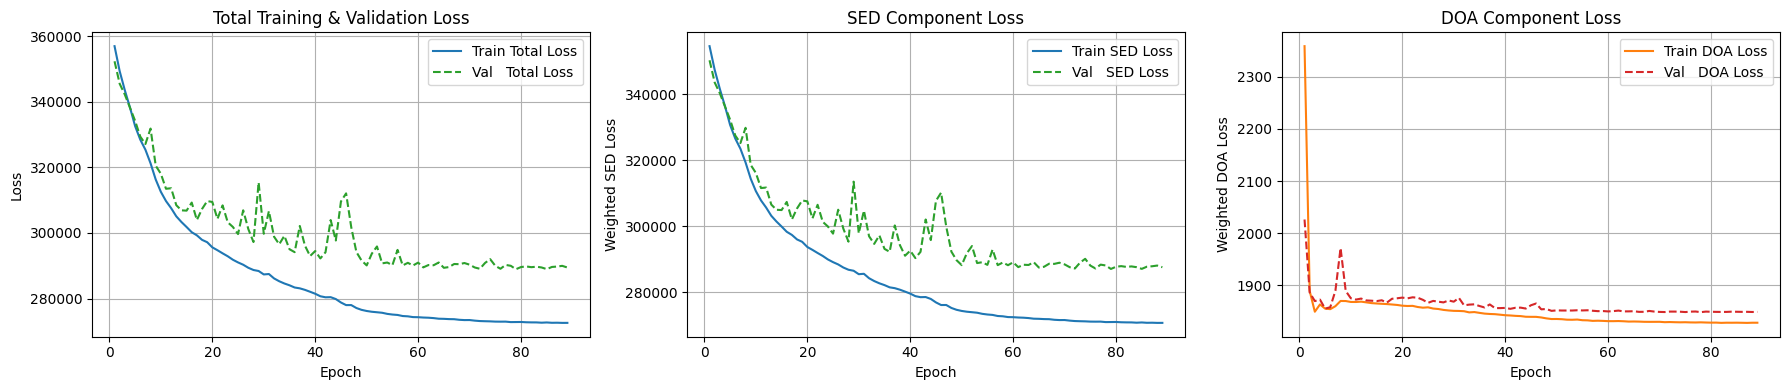

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(metrics['train_loss']) + 1)

plt.figure(figsize=(18, 4))

# ───── Total Loss ─────
plt.subplot(1, 3, 1)
plt.plot(epochs, metrics['train_loss'], label='Train Total Loss', linestyle='-',  color='tab:blue')
plt.plot(epochs, metrics['val_loss'],   label='Val   Total Loss', linestyle='--', color='tab:green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Training & Validation Loss')
plt.legend()
plt.grid(True)

# ───── SED Loss ─────
plt.subplot(1, 3, 2)
plt.plot(epochs, metrics['train_sed_loss'], label='Train SED Loss', linestyle='-',  color='tab:blue')
plt.plot(epochs, metrics['val_sed_loss'],   label='Val   SED Loss', linestyle='--', color='tab:green')
plt.xlabel('Epoch')
plt.ylabel('Weighted SED Loss')
plt.title('SED Component Loss')
plt.legend()
plt.grid(True)

# ───── DOA Loss ─────
plt.subplot(1, 3, 3)
plt.plot(epochs, metrics['train_doa_loss'], label='Train DOA Loss', linestyle='-',  color='tab:orange')
plt.plot(epochs, metrics['val_doa_loss'],   label='Val   DOA Loss', linestyle='--', color='tab:red')
plt.xlabel('Epoch')
plt.ylabel('Weighted DOA Loss')
plt.title('DOA Component Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Evaluating your model
Below I have included an implementation of the DCASE evaluation metrics. You can find the definition of the metrics in the class slides (66+67 from lecture 7), and also on the DCASE evaluation page [here](https://dcase.community/challenge2019/task-sound-event-localization-and-detection#evaluation).

### ❗Deliverables❗
- Load your best performing model in terms of validation loss
- Run the evaluation metrics script below on your test data split and print each of the metrics
- Below is the performance on the 4 metrics from the DCASE baseline system approximately. While it is not necessarily expected that you reproduce this or come close, it should give you a ballpark of moderate success here. Intuitively, error rate at worst = 1 and best = 0, F-score at worse = 0 and best = 1, DOA error at best is 0 degrees, and frame recall at best is 1 and worst 0.
- Comment briefly on your model performance and how it compares to this rough baseline.

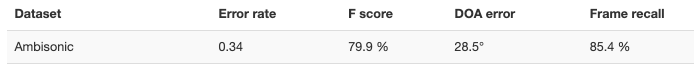



In [14]:
# Just run this code below
from scipy.optimize import linear_sum_assignment
import numpy as np
eps = np.finfo(float).eps

def reshape_3Dto2D(A):
    return A.reshape(A.shape[0] * A.shape[1], A.shape[2])

def f1_overall_framewise(O, T):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
    TP = ((2 * T - O) == 1).sum()
    Nref, Nsys = T.sum(), O.sum()

    prec = float(TP) / float(Nsys + eps)
    recall = float(TP) / float(Nref + eps)
    f1_score = 2 * prec * recall / (prec + recall + eps)
    return f1_score

def er_overall_framewise(O, T):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)

    FP = np.logical_and(T == 0, O == 1).sum(1)
    FN = np.logical_and(T == 1, O == 0).sum(1)

    S = np.minimum(FP, FN).sum()
    D = np.maximum(0, FN-FP).sum()
    I = np.maximum(0, FP-FN).sum()

    Nref = T.sum()
    ER = (S+D+I) / (Nref + 0.0)
    return ER


def f1_overall_1sec(O, T, block_size):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
    new_size = int(np.ceil(float(O.shape[0]) / block_size))
    O_block = np.zeros((new_size, O.shape[1]))
    T_block = np.zeros((new_size, O.shape[1]))
    for i in range(0, new_size):
        O_block[i, :] = np.max(O[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
        T_block[i, :] = np.max(T[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
    return f1_overall_framewise(O_block, T_block)


def er_overall_1sec(O, T, block_size):
    if len(O.shape) == 3:
        O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
    new_size = int(np.ceil(float(O.shape[0]) / block_size))
    O_block = np.zeros((new_size, O.shape[1]))
    T_block = np.zeros((new_size, O.shape[1]))
    for i in range(0, new_size):
        O_block[i, :] = np.max(O[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
        T_block[i, :] = np.max(T[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
    return er_overall_framewise(O_block, T_block)

def distance_between_spherical_coordinates_rad(az1, ele1, az2, ele2):
    """
    Angular distance between two spherical coordinates
    MORE: https://en.wikipedia.org/wiki/Great-circle_distance

    :return: angular distance in degrees
    """
    dist = np.sin(ele1) * np.sin(ele2) + np.cos(ele1) * np.cos(ele2) * np.cos(np.abs(az1 - az2))
    # Making sure the dist values are in -1 to 1 range, else np.arccos kills the job
    dist = np.clip(dist, -1, 1)
    dist = np.arccos(dist) * 180 / np.pi
    return dist


def distance_between_cartesian_coordinates(x1, y1, z1, x2, y2, z2):
    """
    Angular distance between two cartesian coordinates
    MORE: https://en.wikipedia.org/wiki/Great-circle_distance
    Check 'From chord length' section

    :return: angular distance in degrees
    """
    dist = np.sqrt((x1-x2) ** 2 + (y1-y2) ** 2 + (z1-z2) ** 2)
    dist = 2 * np.arcsin(dist / 2.0) * 180/np.pi
    return dist

def distance_between_gt_pred(gt_list_rad, pred_list_rad):
    """
    Shortest distance between two sets of spherical coordinates. Given a set of groundtruth spherical coordinates,
     and its respective predicted coordinates, we calculate the spherical distance between each of the spherical
     coordinate pairs resulting in a matrix of distances, where one axis represents the number of groundtruth
     coordinates and the other the predicted coordinates. The number of estimated peaks need not be the same as in
     groundtruth, thus the distance matrix is not always a square matrix. We use the hungarian algorithm to find the
     least cost in this distance matrix.

    :param gt_list_rad: list of ground-truth spherical coordinates
    :param pred_list_rad: list of predicted spherical coordinates
    :return: cost -  distance
    :return: less - number of DOA's missed
    :return: extra - number of DOA's over-estimated
    """

    gt_len, pred_len = gt_list_rad.shape[0], pred_list_rad.shape[0]
    ind_pairs = np.array([[x, y] for y in range(pred_len) for x in range(gt_len)])
    cost_mat = np.zeros((gt_len, pred_len))

    # Slow implementation
    # cost_mat = np.zeros((gt_len, pred_len))
    # for gt_cnt, gt in enumerate(gt_list_rad):
    #     for pred_cnt, pred in enumerate(pred_list_rad):
    #         cost_mat[gt_cnt, pred_cnt] = distance_between_spherical_coordinates_rad(gt, pred)

    # Fast implementation
    if gt_len and pred_len:
        az1, ele1, az2, ele2 = gt_list_rad[ind_pairs[:, 0], 0], gt_list_rad[ind_pairs[:, 0], 1], \
                               pred_list_rad[ind_pairs[:, 1], 0], pred_list_rad[ind_pairs[:, 1], 1]
        cost_mat[ind_pairs[:, 0], ind_pairs[:, 1]] = distance_between_spherical_coordinates_rad(az1, ele1, az2, ele2)

    row_ind, col_ind = linear_sum_assignment(cost_mat)
    cost = cost_mat[row_ind, col_ind].sum()
    return cost


def compute_sed_scores(pred, gt, nb_frames_1s):
    """
    Computes SED metrics for one second segments

    :param pred: predicted matrix of dimension [nb_frames, nb_classes], with 1 when sound event is active else 0
    :param gt:  reference matrix of dimension [nb_frames, nb_classes], with 1 when sound event is active else 0
    :param nb_frames_1s: integer, number of frames in one second
    :return:
    """
    f1o = f1_overall_1sec(pred, gt, nb_frames_1s)
    ero = er_overall_1sec(pred, gt, nb_frames_1s)
    scores = [ero, f1o]
    return scores


def compute_doa_scores_regr(pred_doa_rad, gt_doa_rad, pred_sed, gt_sed):
    """
    Compute DOA metrics when DOA is estimated using regression approach

    :param pred_doa_rad: predicted doa_labels is of dimension [nb_frames, 2*nb_classes],
                        nb_classes each for azimuth and elevation angles,
                        if active, the DOA values will be in RADIANS, else, it will contain default doa values
    :param gt_doa_rad: reference doa_labels is of dimension [nb_frames, 2*nb_classes],
                    nb_classes each for azimuth and elevation angles,
                    if active, the DOA values will be in RADIANS, else, it will contain default doa values
    :param pred_sed: predicted sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :param gt_sed: reference sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :return:
    """

    nb_src_gt_list = np.zeros(gt_doa_rad.shape[0]).astype(int)
    nb_src_pred_list = np.zeros(gt_doa_rad.shape[0]).astype(int)
    good_frame_cnt = 0
    doa_loss_pred = 0.0
    nb_sed = gt_sed.shape[-1]

    less_est_cnt, less_est_frame_cnt = 0, 0
    more_est_cnt, more_est_frame_cnt = 0, 0

    for frame_cnt, sed_frame in enumerate(gt_sed):
        nb_src_gt_list[frame_cnt] = int(np.sum(sed_frame))
        nb_src_pred_list[frame_cnt] = int(np.sum(pred_sed[frame_cnt]))

        # good_frame_cnt includes frames where the nb active sources were zero in both groundtruth and prediction
        if nb_src_gt_list[frame_cnt] == nb_src_pred_list[frame_cnt]:
            good_frame_cnt = good_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] > nb_src_pred_list[frame_cnt]:
            less_est_cnt = less_est_cnt + nb_src_gt_list[frame_cnt] - nb_src_pred_list[frame_cnt]
            less_est_frame_cnt = less_est_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] < nb_src_pred_list[frame_cnt]:
            more_est_cnt = more_est_cnt + nb_src_pred_list[frame_cnt] - nb_src_gt_list[frame_cnt]
            more_est_frame_cnt = more_est_frame_cnt + 1

        # when nb_ref_doa > nb_estimated_doa, ignores the extra ref doas and scores only the nearest matching doas
        # similarly, when nb_estimated_doa > nb_ref_doa, ignores the extra estimated doa and scores the remaining matching doas
        if nb_src_gt_list[frame_cnt] and nb_src_pred_list[frame_cnt]:
            # DOA Loss with respect to predicted confidence
            sed_frame_gt = gt_sed[frame_cnt]
            doa_frame_gt_azi = gt_doa_rad[frame_cnt][:nb_sed][sed_frame_gt == 1]
            doa_frame_gt_ele = gt_doa_rad[frame_cnt][nb_sed:][sed_frame_gt == 1]

            sed_frame_pred = pred_sed[frame_cnt]
            doa_frame_pred_azi = pred_doa_rad[frame_cnt][:nb_sed][sed_frame_pred == 1]
            doa_frame_pred_ele = pred_doa_rad[frame_cnt][nb_sed:][sed_frame_pred == 1]

            doa_loss_pred += distance_between_gt_pred(np.vstack((doa_frame_gt_azi, doa_frame_gt_ele)).T,
                                                      np.vstack((doa_frame_pred_azi, doa_frame_pred_ele)).T)

    doa_loss_pred_cnt = np.sum(nb_src_pred_list)
    if doa_loss_pred_cnt:
        doa_loss_pred /= doa_loss_pred_cnt

    frame_recall = good_frame_cnt / float(gt_sed.shape[0])
    er_metric = [doa_loss_pred, frame_recall, doa_loss_pred_cnt, good_frame_cnt, more_est_cnt, less_est_cnt]
    return er_metric


def compute_seld_metric(sed_error, doa_error):
    """
    Compute SELD metric from sed and doa errors.

    :param sed_error: [error rate (0 to 1 range), f score (0 to 1 range)]
    :param doa_error: [doa error (in degrees), frame recall (0 to 1 range)]
    :return: seld metric result
    """
    seld_metric = np.mean([
        sed_error[0],
        1 - sed_error[1],
        doa_error[0]/180,
        1 - doa_error[1]]
        )
    return seld_metric


def convert_model_output_xyz_to_azel(pred_xyz):
    """
    Converts model output from (x, y, z) to (azimuth, elevation) in degrees.

    Parameters:
        pred_xyz: np.ndarray of shape (N, T, 3*C)

    Returns:
        pred_azel: np.ndarray of shape (N, T, 2*C)
    """
    N, T, D = pred_xyz.shape
    C = D // 3
    pred_azel = np.zeros((N, T, 2 * C), dtype=np.float32)

    for c in range(C):
        x = pred_xyz[:, :, 3 * c]
        y = pred_xyz[:, :, 3 * c + 1]
        z = pred_xyz[:, :, 3 * c + 2]

        az, el, r = cart2sph(x, y, z)  # returns in degrees
        #print(r)
        pred_azel[:, :, 2 * c] = az
        pred_azel[:, :, 2 * c + 1] = el

    return pred_azel

# Code from: https://github.com/sharathadavanne/seld-dcase2019/blob/master/metrics/evaluation_metrics.py#L468

In [18]:
# TODO : Evaluate your system with these metrics
# Load your best performing model, gather all of the outputs for SED and DOA prediction,
# and run the evaluation functions below.

# 1) Build & compile
model_compiled = torch.compile(SELDModel().to(device), mode='reduce-overhead')

# 2) Load the checkpoint directly
ckpt = torch.load("best_seld_model.pth", map_location=device)
model_compiled.load_state_dict(ckpt['model_state_dict'])

# 3) Extract the underlying original model
model = model_compiled._orig_mod
model.eval()

all_pred_doa, all_gt_doa, all_pred_sed, all_gt_sed = [], [], [], []

with torch.no_grad():
    for feats, gt_doa, gt_sed in test_dataloader:
        feats   = feats.to(device)
        gt_doa  = gt_doa.to(device)
        gt_sed  = gt_sed.to(device)

        sed_logits, doa_pred = model(feats)
        sed_prob = torch.sigmoid(sed_logits)
        #sed_pred = (sed_prob >= 0.5).long()
        sed_pred = (sed_prob >= best_thr).long()

        all_pred_sed.append(sed_pred.cpu().numpy())
        all_gt_sed.append(   gt_sed.cpu().numpy())

        all_pred_doa.append(doa_pred.cpu().numpy())
        all_gt_doa.append(   gt_doa.cpu().numpy())

# stack into (N_clips*T, …)
all_pred_sed = np.concatenate(all_pred_sed, axis=0)
all_gt_sed   = np.concatenate(all_gt_sed,   axis=0)
all_pred_doa = np.concatenate(all_pred_doa, axis=0)
all_gt_doa   = np.concatenate(all_gt_doa,   axis=0)


N, T, C   = all_gt_sed.shape
_, _, D   = all_gt_doa.shape   # D == 3 * C
assert D == 3 * C

# 1) Convert to az/el
pred_doa_rad = convert_model_output_xyz_to_azel(all_pred_doa)  # (N, T, 2C)
gt_doa_rad   = convert_model_output_xyz_to_azel(all_gt_doa)    # (N, T, 2C)

# 2) Flatten (clip, time) ➔ frame
all_pred_sed = all_pred_sed.reshape(N * T, C)      # (n_frames_total, C)
all_gt_sed   = all_gt_sed.reshape(  N * T, C)

pred_doa_rad = pred_doa_rad.reshape(N * T, 2 * C)  # (n_frames_total, 2C)
gt_doa_rad   = gt_doa_rad.reshape(  N * T, 2 * C)

# TODO Run these evaluation functions and print the results!
er, f1 = compute_sed_scores(all_pred_sed, all_gt_sed, nb_frames_1s=50) # error rate, f1
doa_err, frame_recall, _, _, _, _ = compute_doa_scores_regr(pred_doa_rad, gt_doa_rad, all_pred_sed, all_gt_sed) #[doa_loss_pred, frame_recall, doa_loss_pred_cnt, good_frame_cnt, more_est_cnt, less_est_cnt]
compute_seld_metric([er, f1], [doa_err, frame_recall])
seld_score = compute_seld_metric([er, f1], [doa_err, frame_recall])


print("Performance on TEST split:")
print(f"  SED Error Rate:   {er:.4f}")
print(f"  SED F1-score:     {f1:.4f}")
print(f"  DOA Error (deg):  {doa_err:.2f}°")
print(f"  DOA Frame Recall: {frame_recall:.4f}")
print(f"  SELD metric:    {seld_score:.4f}\n")

print("DCASE 2019 Ambisonic baseline (joint‐model):")
print("  SED Error Rate:   0.34")
print("  SED F1-score:     0.799")
print("  DOA Error (deg):  28.5°")
print("  DOA Frame Recall: 0.854")



Performance on TEST split:
  SED Error Rate:   7.0214
  SED F1-score:     0.2217
  DOA Error (deg):  2.26°
  DOA Frame Recall: 0.0000
  SELD metric:    2.2031

DCASE 2019 Ambisonic baseline (joint‐model):
  SED Error Rate:   0.34
  SED F1-score:     0.799
  DOA Error (deg):  28.5°
  DOA Frame Recall: 0.854


# Bonus (4 points available)

Above, you implemented a sound event localization and detection (SELD) model using magnitude and phase spectrogram features extracted from First-Order Ambisonic (FOA) recordings. In this extension, you will modify your dataloader and feature extraction pipeline to instead use SRP-PHAT (Steered Response Power with Phase Transform) features as the input to your model, as discussed in class.

Your new model input shape will be `(batch, T, U, V)` where U corresponds to the number of azimuth angular positions, and V corresponds to the number of  elevation angular positions in the position grid you design. The DCASE data has azimuths expected in [-180,180] and elevation in [-40,40]. Design a 36x36 grid with a 5 degree resolution, so that final SRP-PHAT input feature shape should end up as `(batch, T, U=72, V=16)`.


### ❗Deliverables❗
- GCC and SRP-PHAT implemented (involves designing an angular grid of your choice) in a new dataloader (2 points)
- New model class or adjusted instantiation of your existing class that can handle the new feature shape (0.5 points)
- New model trained and validated, with loss plots and evaluation metrics compute. (1 point)
- Reflection on differences between the features and model performance and your hypothesis on why things perform the way they do. (0.5 points)


In [ ]:
# Angular Grid

azs = np.arrange(-180,180,5)

els = np.arrange(-40,41,5)

els = els[:-1]

U, V = len(azs), len(els)


In [ ]:
class SRPPHATDataset(Dataset):
    def __init__(self, csv_dir, audio_dir, data_splt, cache_dir=None, fs=48000, frame_hop = 0.02):

      super().__init__()

